# Environment Setup

Import all necessary libraries and modules from the Visual Intelligence project, including the Runner class and model classes.


In [1]:
from src.config import PATH_CONFIG
from src.models.scatnet import ScatNetImageClassifier
from src.models.cnn import CNNImageClassifier
from src.training.metrics import TrainingMetrics
from src.training.training import CrossValidationTrainer
from src.visualization.dataset_vis import DatasetVisualizer
from src.config import BENIGN, ADENOCARCINOMA
from src.models.utils import ModelAnalyzer
from main import Runner  # Import the Runner class from the main module

/home/lore/Documents/GitHub/VisualIntelligence/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare Dataset


In [2]:
# Create a Runner instance
runner = Runner()  # Initialize the Runner instance

# Use the prepare_dataset method to load and preprocess the dataset
runner.prepare_dataset()

# Print dataset preparation details
print(f"Dataset prepared with {len(runner.df)} samples.")
print(f"Training splits: {len(runner.train_splits)}")
print(f"Validation splits: {len(runner.val_splits)}")
print(f"Dataset statistics: {runner.stats}")

Dataset found in dataset_orig
Dataset found in dataset
Dataset prepared with 10000 samples.
Training splits: 9000
Validation splits: 1000
Dataset statistics: {'0': {'mean': [0.6426169872283936], 'std': [0.1703673005104065]}, '1': {'mean': [0.6423331499099731], 'std': [0.1705634593963623]}, '2': {'mean': [0.6422251462936401], 'std': [0.17044061422348022]}, '3': {'mean': [0.6422973275184631], 'std': [0.17046070098876953]}, '4': {'mean': [0.6422476172447205], 'std': [0.17042039334774017]}, '5': {'mean': [0.6423108577728271], 'std': [0.17041423916816711]}, '6': {'mean': [0.6423872709274292], 'std': [0.17058666050434113]}, '7': {'mean': [0.6423932909965515], 'std': [0.17032627761363983]}, '8': {'mean': [0.6424703598022461], 'std': [0.17026516795158386]}, '9': {'mean': [0.6422606706619263], 'std': [0.17042158544063568]}}


# Inspect the dataset


100%|██████████| 10000/10000 [00:02<00:00, 3354.48it/s]


Unique shapes: [[768 768]]


Processing color for dataset_orig/adenocarcinoma: 100%|██████████| 5000/5000 [01:02<00:00, 80.49it/s]


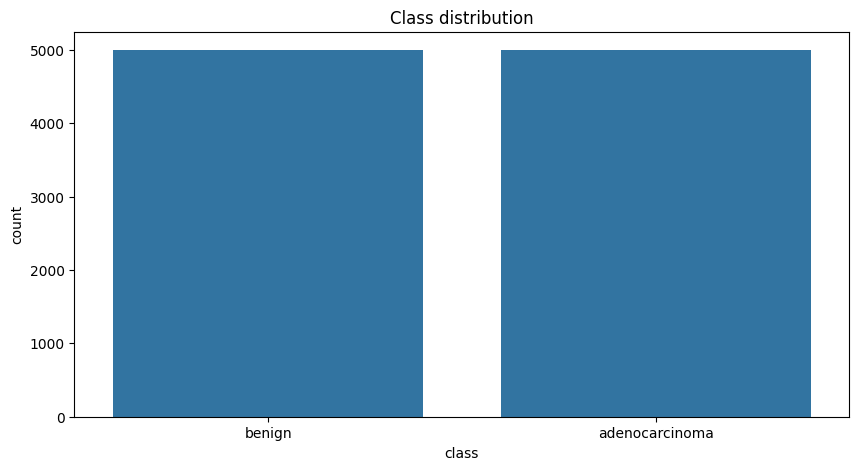

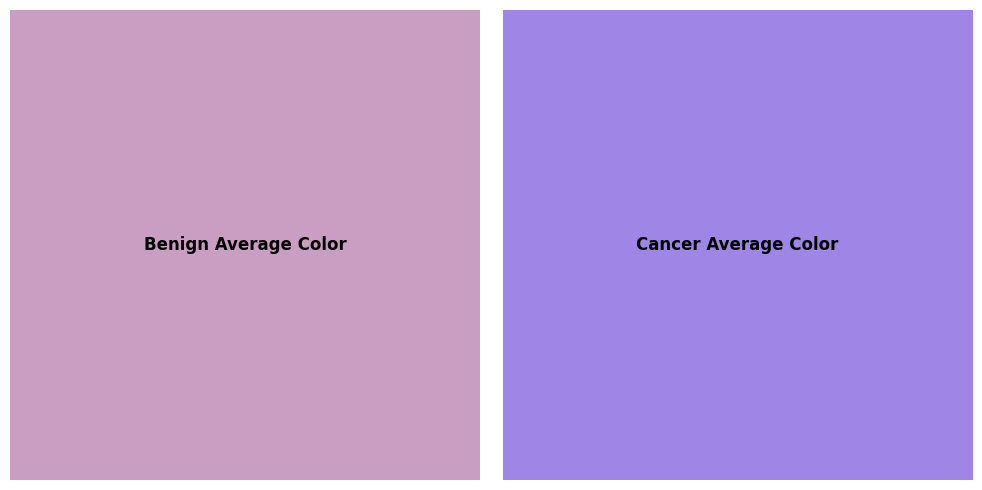

In [3]:
vis = DatasetVisualizer(runner.df)  # Initialize the DatasetVisualizer
vis.find_unique_shapes()  # Find unique shapes in the dataset
vis.plot_class_distribution()  # Plot the class distribution
benign_color, _ = vis.compute_class_color(f"{PATH_CONFIG.dataset_orig_path}/{BENIGN}")
cancer_color, _ = vis.compute_class_color(
    f"{PATH_CONFIG.dataset_orig_path}/{ADENOCARCINOMA}"
)
vis.show_class_colors(benign_color, cancer_color)  

# Show processed and augmented images


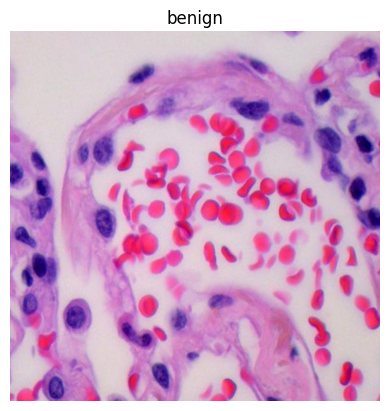

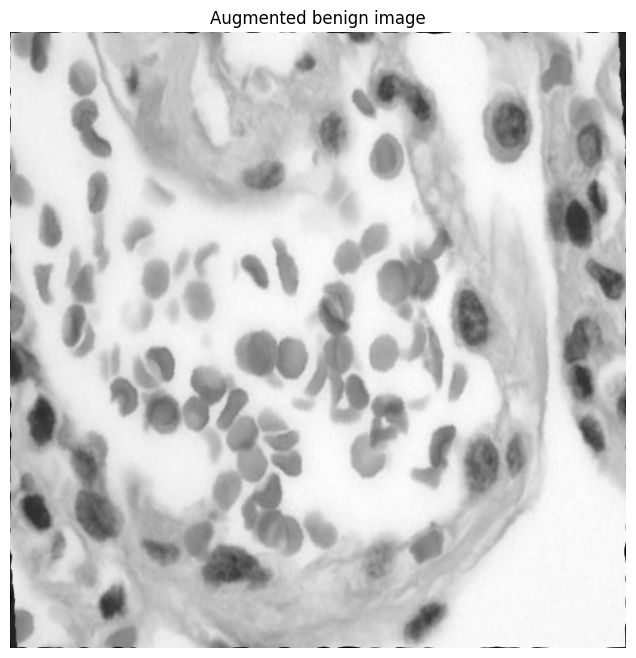

In [4]:
idx = 4981
vis.show_dataset_image(idx=idx)  # Show a random image from the dataset
vis.show_augmented_image(idx=idx)

# Model Loading

Explore the get_model method to either load a model from a checkpoint or create a new model instance.


In [5]:
# Explore the get_model method to either load a model from a checkpoint or create a new model instance
model_type = CNNImageClassifier
model_type = ScatNetImageClassifier
runner.set_model_class(model_type)  # Set the model class to be used

# Load a model from a checkpoint or create a new model instance
#checkpoint_id = None  # Set to None to create a new model instance
checkpoint_id = 9  # Set to a specific checkpoint ID if loading from a checkpoint
model = runner.get_model(checkpoint_id=checkpoint_id)

# Print model details
if checkpoint_id is not None:
    print(f"Model loaded from checkpoint {checkpoint_id}: {model}")
else:
    print(f"New model instance created: {model}")

Loading model from checkpoint 9
Model loaded from checkpoint 9: ScatNetImageClassifier(
  (scattering): Scattering2D()
  (global_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (classifier): FeatureClassifier(
    (fc1): Linear(in_features=3472, out_features=16, bias=True)
    (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (do): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [6]:
# Inspect the model architecture

train_loader, val_loader = runner.get_loaders()
model_analyzer = ModelAnalyzer(model, train_loader, val_loader)
model_analyzer.inspect_model_architecture()

Dataset found in dataset_orig
Dataset found in dataset
Val loader length: 16
Device: cuda
Sample output: tensor([[ 0.8641, -0.3734]], device='cuda:0')

===== Model Architecture =====
Model Class: ScatNetImageClassifier
Model Structure:
ScatNetImageClassifier(
  (scattering): Scattering2D()
  (global_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (classifier): FeatureClassifier(
    (fc1): Linear(in_features=3472, out_features=16, bias=True)
    (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (do): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=16, out_features=2, bias=True)
  )
)

===== Detailed Model Summary =====
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ScatNetImageClassifier                   [1, 1, 768, 768]          [1, 2]                    --                        --                        --


# Model Training

Implement the train_model method to train a model from scratch using cross-validation.


In [7]:
# Train the model using the train_model method
print(f"Training {runner.model_class.__name__} model...")

# Train the model using cross-validation
cv_trainer = CrossValidationTrainer(model)
#cv_trainer.train_all_folds(runner.df, num_folds=10)

# Print completion message
print("Model training completed.")

Training ScatNetImageClassifier model...
Model training completed.


# Training Statistics


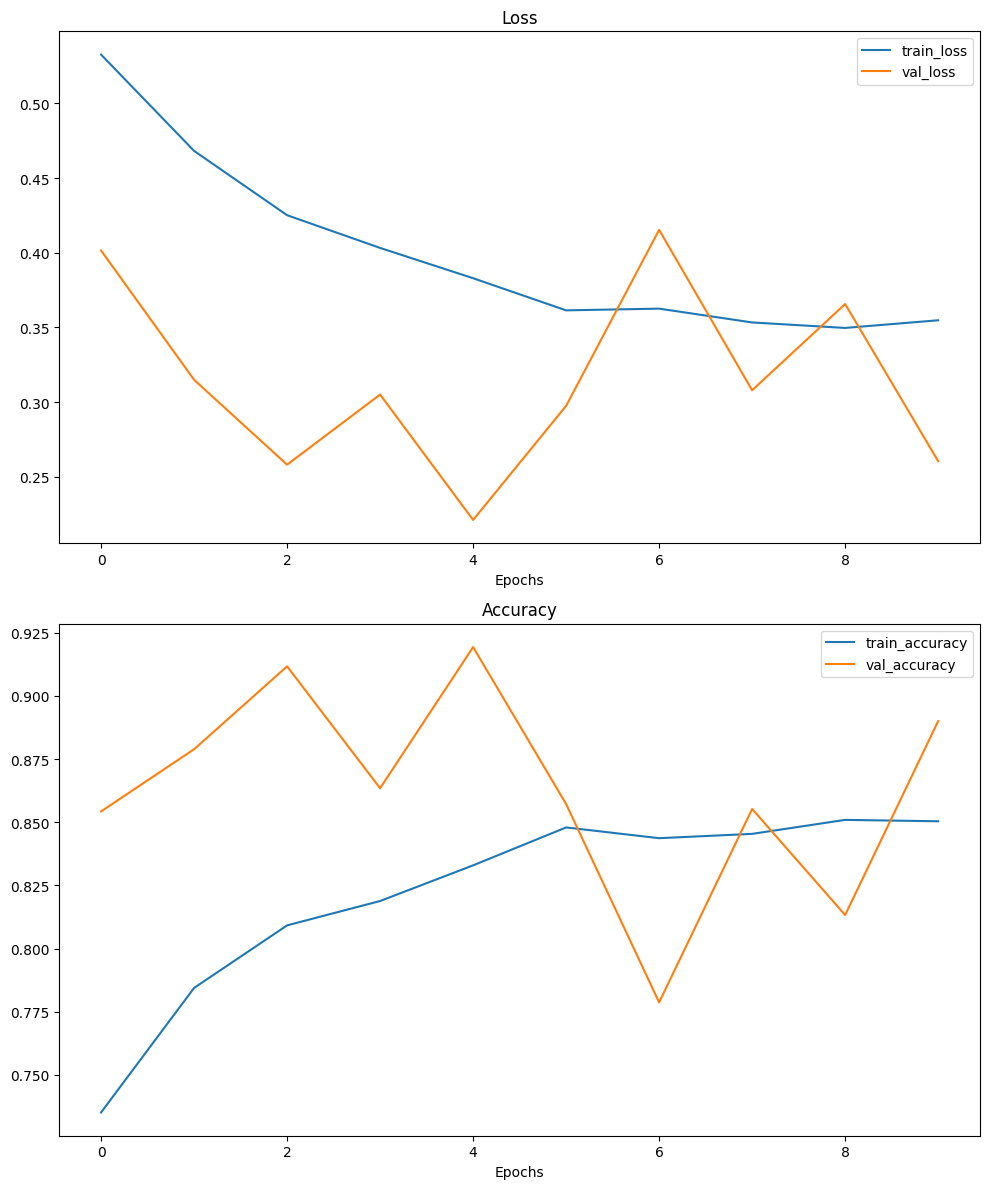

In [8]:
tm = TrainingMetrics()  # Initialize the TrainingMetrics instance
tm.show_training_results(fold_id=0, model_class=model_type, vertical_layout=True)

# Model Evaluation

Use the compute_metrics method to evaluate model performance across all folds.


In [10]:
# Evaluate the model using the compute_metrics method
print("Evaluating model performance across all folds...")

# Load model from checkpoint
model = runner.get_model(checkpoint_id=9)

# Setup analyzer and compute metrics
metrics = tm.compute_metrics_all_folds(runner.data_manager, model.__class__)

print("Model evaluation completed.")

Evaluating model performance across all folds...
Loading model from checkpoint 9
Fold 0 - Accuracy: 0.9210, F1 Score: 0.9209
Fold 1 - Accuracy: 0.8910, F1 Score: 0.8868
Fold 2 - Accuracy: 0.9290, F1 Score: 0.9279
Fold 3 - Accuracy: 0.9250, F1 Score: 0.9208
Fold 4 - Accuracy: 0.9380, F1 Score: 0.9371
Fold 5 - Accuracy: 0.9440, F1 Score: 0.9443
Fold 6 - Accuracy: 0.9510, F1 Score: 0.9506
Fold 7 - Accuracy: 0.9380, F1 Score: 0.9358
Fold 8 - Accuracy: 0.9230, F1 Score: 0.9197
Fold 9 - Accuracy: 0.9390, F1 Score: 0.9388

Mean Accuracy: 0.9299 ± 0.0159
Mean F1 Score: 0.9283 ± 0.0170
Model evaluation completed.


# Filter Visualization

Use the show_filters method to visualize the filters learned by the model.


Visualizing filters for model checkpoint 9...
Loading model from checkpoint 9


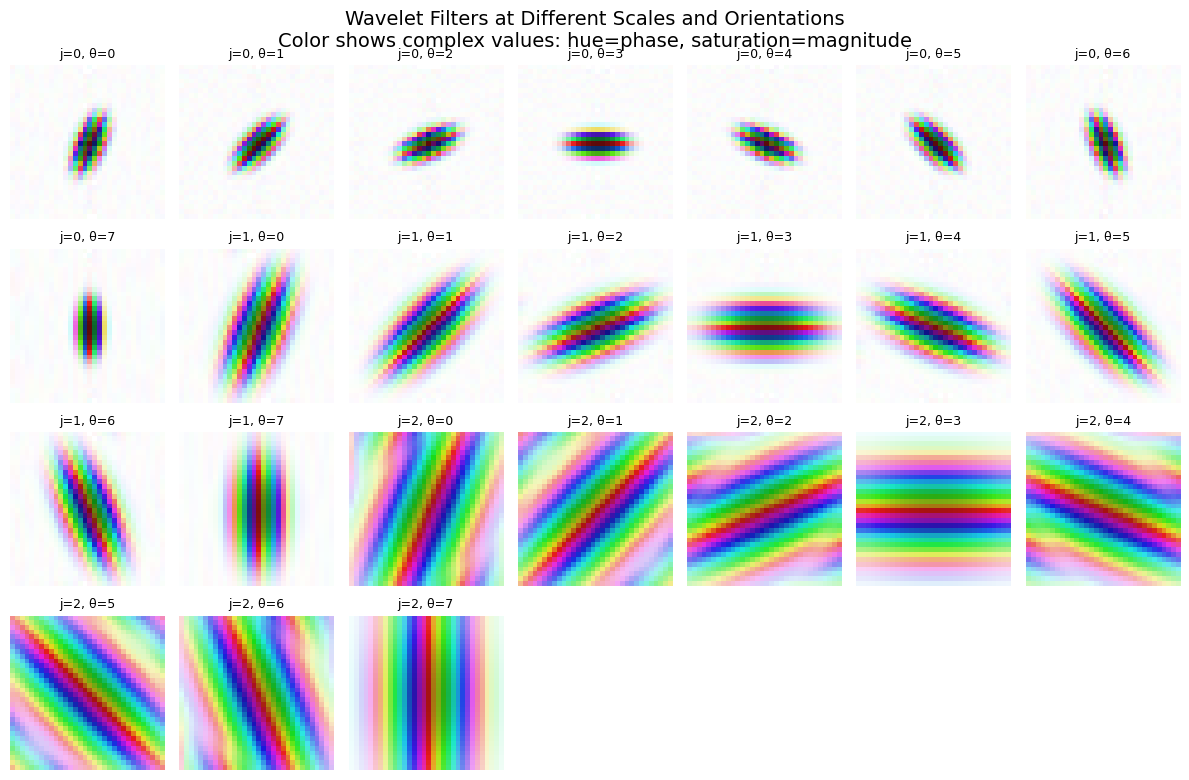

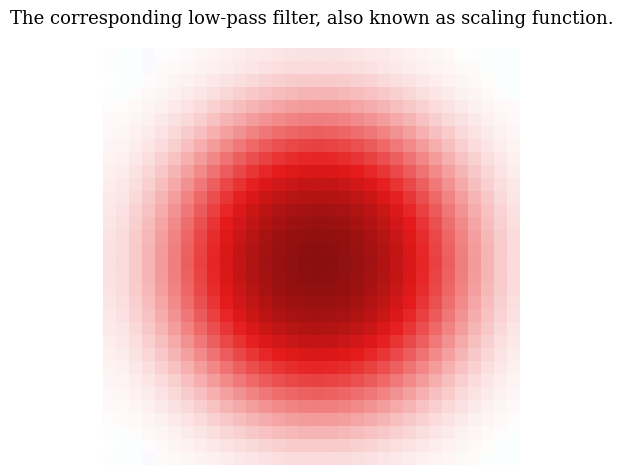

Filters for model checkpoint 9 visualized successfully.


In [11]:
# Filter Visualization

# Visualize the filters learned by the model using the show_filters method
checkpoint_id = 9  # Specify the checkpoint ID to load the model

# Call the show_filters method to visualize the filters
print(f"Visualizing filters for model checkpoint {checkpoint_id}...")
runner.show_filters(checkpoint_id=checkpoint_id)

# Print a message indicating the visualization is complete
print(f"Filters for model checkpoint {checkpoint_id} visualized successfully.")

# Explainable AI Analysis

Implement the run_xai_analysis method to apply XAI techniques on sample images for model interpretation.


Running XAI analysis on image index 4116 using checkpoint 9...
Dataset found in dataset_orig
Dataset found in dataset
Loading model from checkpoint 9
Predicted class: 0


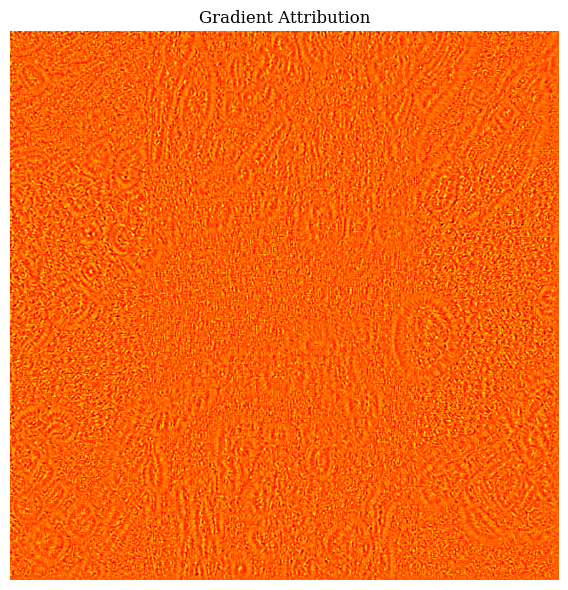

Predicted class: 0


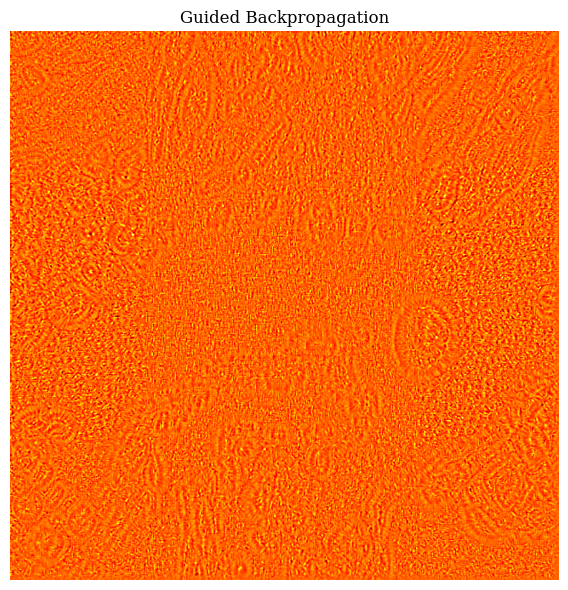

XAI analysis completed for image index 4116.
Image label: benign


In [12]:
# Explainable AI Analysis: Apply XAI techniques on sample images for model interpretation

# Specify the checkpoint ID and image index for analysis
checkpoint_id = 9  # Specify the checkpoint ID to load the model
image_idx = 4116  # Specify the index of the image to analyze

# Run the XAI analysis using the run_xai_analysis method
print(
    f"Running XAI analysis on image index {image_idx} using checkpoint {checkpoint_id}..."
)
image, label = runner.run_xai_analysis(checkpoint_id=checkpoint_id, idx=image_idx, show_original=False)

# Display the analyzed image and its label
print(f"XAI analysis completed for image index {image_idx}.")
print(f"Image label: {label}")

# Explainable AI Analysis using Captum

Running Captum analysis on image index 4116 using checkpoint 9...
Dataset found in dataset_orig
Dataset found in dataset
Loading model from checkpoint 9
Input tensor shape: torch.Size([1, 1, 768, 768])
Using predicted class: 0
Analyzing with methods: ['Guided Backpropagation']
Preparing Guided Backpropagation...
Calculating Guided Backpropagation attribution...


/home/lore/Documents/GitHub/VisualIntelligence/.venv/lib/python3.11/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


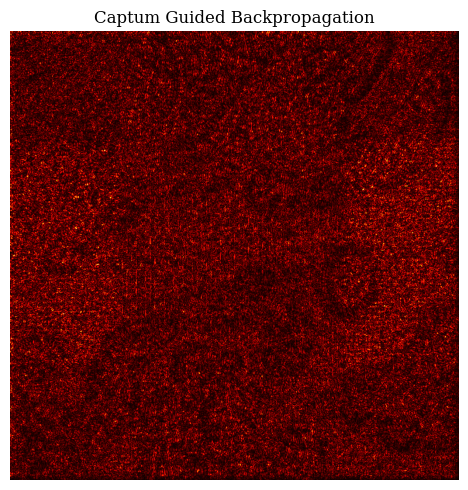

In [14]:
# Model Attribution Analysis: Generate and visualize model attributions using Captum

# Specify the checkpoint ID and image index for Captum analysis
checkpoint_id = 9  # Specify the checkpoint ID to load the model
image_idx = 4116  # Specify the index of the image to analyze

# Run the Captum analysis using the run_captum_analysis method
print(
    f"Running Captum analysis on image index {image_idx} using checkpoint {checkpoint_id}..."
)
image, label, attributions = runner.run_captum_analysis(
    checkpoint_id=checkpoint_id, idx=image_idx, show_original=False
)